**GOALS**:
- Use a pre-trained CNN features to evaluate classification feasibility.
- Train a classifier on those features if it seems promising.
- Use data augmentation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
from tqdm import tqdm
import data_science_functions as ds
import project_tools as pt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-06-12 12:17:27.937039: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 12:17:28.314656: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 12:17:28.316179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 12:17:29.954207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0


2023-06-12 12:17:31.471974: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


**Table of contents**<a id='toc0_'></a>    
- 1. [Images and labels.](#toc1_)    
- 2. [Evaluate feasibility with the VGG16 model used for feature extraction.](#toc2_)    
  - 2.1. [Download the model](#toc2_1_)    
  - 2.2. [Extract features from the model](#toc2_2_)    
  - 2.3. [Evaluate classification feasibility with a t-SNE visualization.](#toc2_3_)    
- 3. [Evaluate feasibility with the mobilenet model used for feature extraction.](#toc3_)    
  - 3.1. [Download the model and drop the last layer](#toc3_1_)    
  - 3.2. [Extract features from the model](#toc3_2_)    
  - 3.3. [Evaluate classification feasibility with a t-SNE visualization.](#toc3_3_)    
- 4. [Supervised classification](#toc4_)    
  - 4.1. [Preparing the directories for TF compatibility](#toc4_1_)    
  - 4.2. [Generate train and evaluation sets](#toc4_2_)    
  - 4.3. [Create the classification model based on VGG16](#toc4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Images and labels.

In [3]:
metadata_filename = './data/Flipkart/Images/metadata.csv.gz'
metadata = pd.read_csv(metadata_filename)
metadata.head()

,image,shape,n_pixels,mean_gray,min_gray,max_gray,category
0,009099b1f6e1e8f893ec29a7023153c4.jpg,"(1162, 687, 3)",798294,172.415863,0,255,watches
1,0096e89cc25a8b96fb9808716406fe94.jpg,"(904, 1478, 3)",1336112,156.565580,0,255,kitchen_&_dining
2,00cbbc837d340fa163d11e169fbdb952.jpg,"(326, 1347, 3)",439122,192.004357,9,255,home_furnishing
3,00d84a518e0550612fcfcba3b02b6255.jpg,"(857, 1100, 3)",942700,168.342569,0,255,beauty_and_personal_care
4,00e966a5049a262cfc72e6bbf68b80e7.jpg,"(1100, 962, 3)",1058200,171.585655,3,255,computers


# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Evaluate feasibility with the VGG16 model used for feature extraction.

## 2.1.  [&#9650;](#toc0_) <a id='toc2_1_'></a>Download the model

In [3]:
base_model = VGG16(weights="imagenet")
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 2.2.  [&#9650;](#toc0_) <a id='toc2_2_'></a>Extract features from the model

In [20]:
images_features = []
image_dir = './data/Flipkart/Images/'

for name in tqdm(metadata.image):
    image = load_img(os.path.join(image_dir, name), target_size=(224, 224))
    # Note : it is possible to keep image ratio in load_img
    input_arr = img_to_array(image) 
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = preprocess_input(input_arr)
    images_features.append(model.predict(input_arr, verbose=0)[0])

images_features = np.asarray(images_features)
images_features.shape


 32%|███▏      | 338/1050 [04:13<09:16,  1.28it/s]/home/louberehc/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [14:13<00:00,  1.23it/s]


(1050, 4096)

## 2.3.  [&#9650;](#toc0_) <a id='toc2_3_'></a>Evaluate classification feasibility with a t-SNE visualization.

In [23]:
print(images_features.shape)
pca = PCA(n_components=0.99)
X_pca= pca.fit_transform(images_features)
print(f'reduced to {pca.n_components_} dimensions.')

(1050, 4096)
reduced to 803 dimensions.


In [24]:
import time

t0 = time.time()

tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

duration = time.time() - t0
print("T-SNE took : ", "%3.2f" % duration, "secondes")

T-SNE took :  4.34 secondes


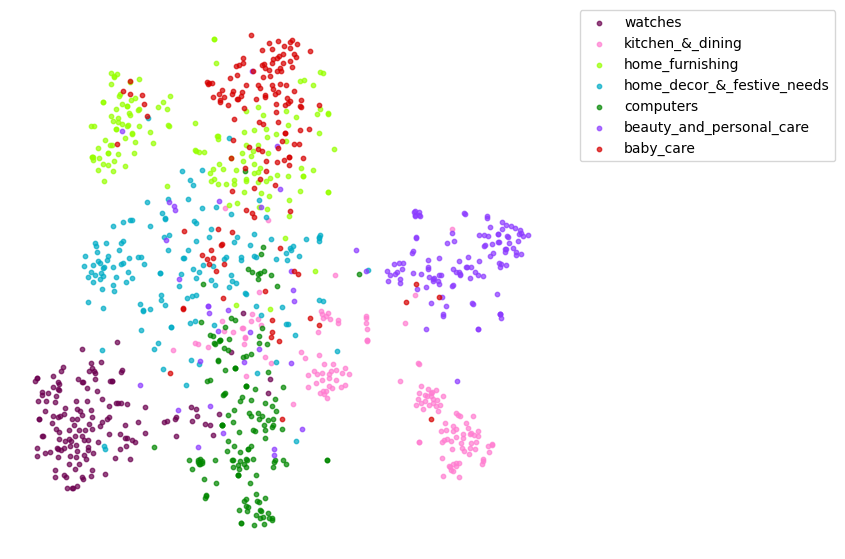

In [26]:
ds.display_tsne(X_tsne, illustrative_var=metadata.category)

The VGG16 returns much more relevant features than what we got from SIFT and ORB for the classification task we are willing to do.

Let's evaluate scores we would obtain if we try unsupervised classifications :

In [34]:
kmeans = KMeans(n_clusters=7, n_init=5)
pca = PCA(n_components=0.99)
tsne = TSNE(n_components=2, perplexity=30)

pipelines = {
    'kmeans': make_pipeline(kmeans),
    'pca_kmeans': make_pipeline(pca, kmeans),
    'tsne_kmeans': make_pipeline(tsne, kmeans),
}


true_labels = metadata.category

# Results containers
evaluations = []
evaluations_std = []

for pipe_name, pipe in pipelines.items():
    
    model_name = (
        pipe_name 
        + '\non VGG16 features'
    )
    
    print('***********')
    print(model_name)
    ds.fit_and_evaluate_clusters(
        model=pipe,
        X=images_features,
        labels=true_labels,
        name=model_name,
        evaluations=evaluations,
        evaluations_std=evaluations_std,
    ) 

***********
kmeans
on VGG16 features
clustering done in 1.45 ± 0.13 s 
Homogeneity: 0.575 ± 0.010
Completeness: 0.605 ± 0.015
V-measure: 0.590 ± 0.012
Adjusted Rand-Index: 0.465 ± 0.018
Silhouette: 0.086 ± 0.002
***********
pca_kmeans
on VGG16 features
clustering done in 2.42 ± 0.11 s 
Homogeneity: 0.579 ± 0.010
Completeness: 0.609 ± 0.016
V-measure: 0.594 ± 0.013
Adjusted Rand-Index: 0.471 ± 0.020
Silhouette: 0.086 ± 0.002
***********
tsne_kmeans
on VGG16 features
clustering done in 6.15 ± 0.43 s 
Homogeneity: 0.555 ± 0.002
Completeness: 0.565 ± 0.002
V-measure: 0.560 ± 0.002
Adjusted Rand-Index: 0.447 ± 0.001
Silhouette: 0.074 ± 0.000


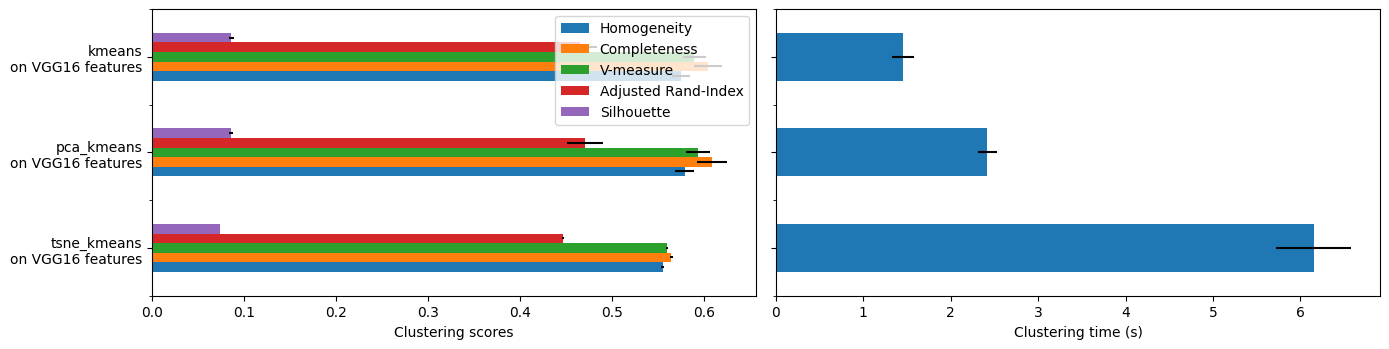

In [35]:
ds.display_clusters_scores(evaluations, evaluations_std)

The t-SNE visual and those scores prove the feasibility of classifying. Let's save those features in a dataframe for later use, and let's try to supervise a classifier.

In [37]:
img_fts = pd.DataFrame(
    images_features,
    index=metadata.image,
)
print(img_fts.shape)
img_fts.head()

(1050, 4096)


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
image,,,,,,,,,,,,,,,,,,,,,
009099b1f6e1e8f893ec29a7023153c4.jpg,2.591889,2.726005,0.000000,3.297257,1.653290,0.000000,0.000000,0.000000,0.0,2.143805,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.869046,0.000000,2.940915
0096e89cc25a8b96fb9808716406fe94.jpg,0.000000,0.000000,0.000000,2.216237,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,0.0,1.620237,2.385922,0.045931,0.399317,0.000000,0.157195,2.914562
00cbbc837d340fa163d11e169fbdb952.jpg,0.000000,0.000000,0.000000,2.043372,0.000000,0.498197,2.621285,0.000000,0.0,0.000000,...,2.97961,0.008590,0.0,1.337796,0.000000,3.764513,0.000000,0.708812,0.000000,0.000000
00d84a518e0550612fcfcba3b02b6255.jpg,0.000000,0.000000,0.000000,0.000000,0.146764,0.000000,0.000000,1.364243,0.0,1.564342,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.578789
00e966a5049a262cfc72e6bbf68b80e7.jpg,0.000000,0.000000,1.530867,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.526205,0.0,0.053459,0.000000,1.196185,0.145275,0.000000,0.000000,3.437492


In [38]:
img_fts.to_csv('VGG16_features.csv.gz')

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Evaluate feasibility with the lighter MobileNet model.

## 3.1.  [&#9650;](#toc0_) <a id='toc3_1_'></a>Download the model and drop the last layers

In [4]:
mobile = tf.keras.applications.mobilenet.MobileNet()
model = Model(inputs=mobile.inputs, outputs=mobile.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

## 3.2.  [&#9650;](#toc0_) <a id='toc3_2_'></a>Extract features from the model

In [5]:
images_features = []
image_dir = './data/Flipkart/Images/'

for name in tqdm(metadata.image):
    image = load_img(os.path.join(image_dir, name), target_size=(224, 224))
    input_arr = img_to_array(image) 
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = tf.keras.applications.mobilenet.preprocess_input(input_arr)
    images_features.append(model.predict(input_arr, verbose=0)[0])

images_features = np.asarray(images_features)
images_features.shape


 32%|███▏      | 337/1050 [00:37<02:02,  5.84it/s]/home/louberehc/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [02:12<00:00,  7.92it/s]


(1050, 1000)

In [7]:
metadata.iloc[335:338, :]

,image,shape,n_pixels,mean_gray,min_gray,max_gray,category
335,54749618b728306f9b3dc518dec315ee.jpg,"(581, 400, 3)",232400,172.012794,0,255,watches
336,54754ccd18f2a75c53de68806176392a.jpg,"(809, 1100, 3)",889900,243.298399,57,255,computers
337,5479bb7028827d60000720a2c135976a.jpg,"(1000, 302, 3)",302000,84.091812,0,255,watches


## 3.3.  [&#9650;](#toc0_) <a id='toc3_3_'></a>Evaluate classification feasibility with a t-SNE visualization.

In [8]:
print(images_features.shape)
pca = PCA(n_components=0.99)
X_pca= pca.fit_transform(images_features)
print(f'reduced to {pca.n_components_} dimensions.')

(1050, 1000)
reduced to 406 dimensions.


In [9]:
import time

t0 = time.time()

tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

duration = time.time() - t0
print("T-SNE took : ", "%3.2f" % duration, "secondes")

T-SNE took :  4.89 secondes


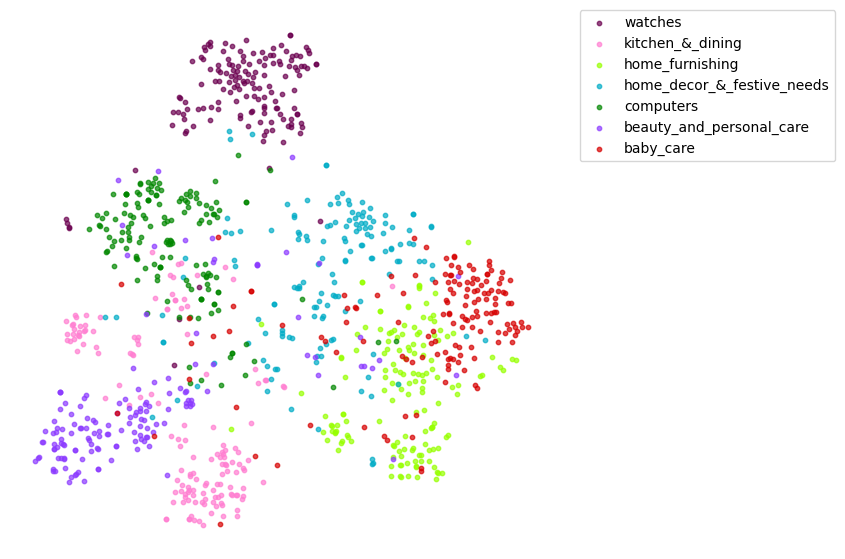

In [10]:
ds.display_tsne(X_tsne, illustrative_var=metadata.category)

The MobileNet model also nice results.

Let's evaluate scores we would obtain if we try unsupervised classifications :

In [11]:
kmeans = KMeans(n_clusters=7, n_init=5)
pca = PCA(n_components=0.99)
tsne = TSNE(n_components=2, perplexity=30)

pipelines = {
    'kmeans': make_pipeline(kmeans),
    'pca_kmeans': make_pipeline(pca, kmeans),
    'tsne_kmeans': make_pipeline(tsne, kmeans),
}


true_labels = metadata.category

# Results containers
evaluations = []
evaluations_std = []

for pipe_name, pipe in pipelines.items():
    
    model_name = (
        pipe_name 
        + '\non MobileNet features'
    )
    
    print('***********')
    print(model_name)
    ds.fit_and_evaluate_clusters(
        model=pipe,
        X=images_features,
        labels=true_labels,
        name=model_name,
        evaluations=evaluations,
        evaluations_std=evaluations_std,
    ) 

***********
kmeans
on MobileNet features
clustering done in 0.59 ± 0.06 s 
Homogeneity: 0.593 ± 0.007
Completeness: 0.602 ± 0.005
V-measure: 0.598 ± 0.006
Adjusted Rand-Index: 0.532 ± 0.018
Silhouette: 0.088 ± 0.000
***********
pca_kmeans
on MobileNet features
clustering done in 0.88 ± 0.09 s 
Homogeneity: 0.598 ± 0.004
Completeness: 0.606 ± 0.006
V-measure: 0.602 ± 0.005
Adjusted Rand-Index: 0.543 ± 0.005
Silhouette: 0.087 ± 0.000
***********
tsne_kmeans
on MobileNet features
clustering done in 5.13 ± 0.51 s 
Homogeneity: 0.576 ± 0.001
Completeness: 0.578 ± 0.001
V-measure: 0.577 ± 0.001
Adjusted Rand-Index: 0.525 ± 0.002
Silhouette: 0.066 ± 0.001


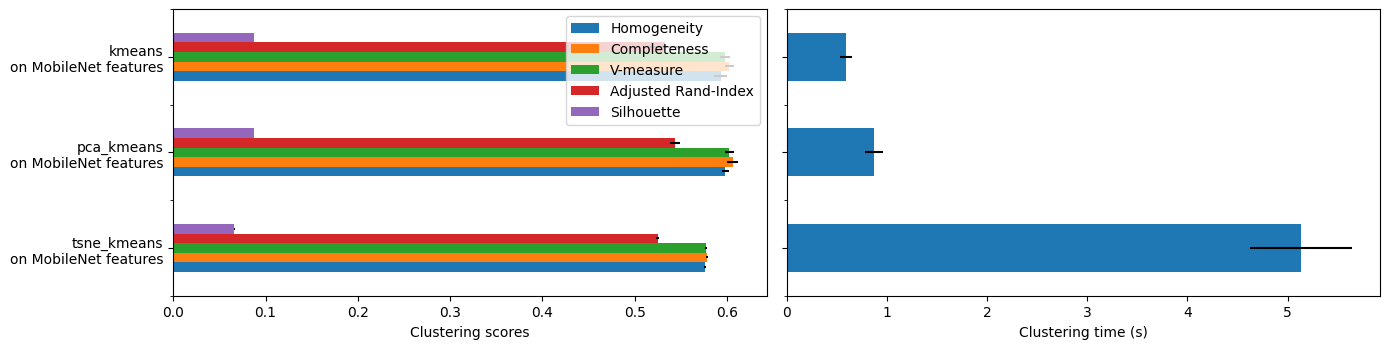

In [12]:
ds.display_clusters_scores(evaluations, evaluations_std)

We even get better results than VGG16.

As it is a lighter model that provides better results, it is the one I am going to fine-tune in the next section.

# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Supervised classification

## 4.1.  [&#9650;](#toc0_) <a id='toc4_1_'></a>Preparing the directories for TF compatibility

I first need to create directories compatible with tf.keras.utils.image_dataset_from_directory function.

A main directory with class subdirectories.

Note : Sometimes, it can be convenient to subdivide the main directory into 3 directories (train, eval, test) before filling it with class subdirectories.

In [ ]:
main_dir_name = 'Flipkart_products_images'
if not os.path.exists(main_dir_name):
    os.mkdir(main_dir_name)

In [ ]:
# Format class names
class_names = [cl.replace('&', 'and') for cl in metadata.category.unique()]
class_names 

['watches',
 'kitchen_and_dining',
 'home_furnishing',
 'beauty_and_personal_care',
 'computers',
 'home_decor_and_festive_needs',
 'baby_care']

In [ ]:
for cl in class_names:
    sub_dir = os.path.join(main_dir_name, cl)
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir) 

In [ ]:
!tree ./Flipkart_products_images

./Flipkart_products_images
├── baby_care
├── beauty_and_personal_care
├── computers
├── home_decor_and_festive_needs
├── home_furnishing
├── kitchen_and_dining
└── watches

7 directories, 0 files


In [ ]:
# Load info about images
img_fts = pd.read_csv('VGG16_features.csv.gz', index_col='image')
display(img_fts.head())

metadata = pd.read_csv('./data/Flipkart/Images/metadata.csv.gz')
metadata.head()


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
image,,,,,,,,,,,,,,,,,,,,,
009099b1f6e1e8f893ec29a7023153c4.jpg,2.591889,2.726005,0.000000,3.297257,1.653290,0.000000,0.000000,0.000000,0.0,2.143805,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.869046,0.000000,2.940915
0096e89cc25a8b96fb9808716406fe94.jpg,0.000000,0.000000,0.000000,2.216237,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,0.0,1.620237,2.385922,0.045931,0.399317,0.000000,0.157195,2.914562
00cbbc837d340fa163d11e169fbdb952.jpg,0.000000,0.000000,0.000000,2.043372,0.000000,0.498197,2.621285,0.000000,0.0,0.000000,...,2.97961,0.008590,0.0,1.337796,0.000000,3.764512,0.000000,0.708812,0.000000,0.000000
00d84a518e0550612fcfcba3b02b6255.jpg,0.000000,0.000000,0.000000,0.000000,0.146764,0.000000,0.000000,1.364243,0.0,1.564342,...,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.578789
00e966a5049a262cfc72e6bbf68b80e7.jpg,0.000000,0.000000,1.530867,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.00000,0.526205,0.0,0.053459,0.000000,1.196185,0.145275,0.000000,0.000000,3.437492


,image,shape,n_pixels,mean_gray,min_gray,max_gray,category
0,009099b1f6e1e8f893ec29a7023153c4.jpg,"(1162, 687, 3)",798294,172.415863,0,255,watches
1,0096e89cc25a8b96fb9808716406fe94.jpg,"(904, 1478, 3)",1336112,156.565580,0,255,kitchen_&_dining
2,00cbbc837d340fa163d11e169fbdb952.jpg,"(326, 1347, 3)",439122,192.004357,9,255,home_furnishing
3,00d84a518e0550612fcfcba3b02b6255.jpg,"(857, 1100, 3)",942700,168.342569,0,255,beauty_and_personal_care
4,00e966a5049a262cfc72e6bbf68b80e7.jpg,"(1100, 962, 3)",1058200,171.585655,3,255,computers


In [ ]:
import shutil

original_img_dir = './data/Flipkart/Images/'

# Format category to sub-directory name.
metadata['category'] = metadata.category.str.replace('&', 'and')

for cl_name, cl_df in metadata.groupby('category').__iter__():
    # Build the relative image path.
    cl_img_paths = original_img_dir + cl_df.image
    for img_path in cl_img_paths:
        dst_dir = os.path.join(main_dir_name, cl_name)
        # Copy the image to its class sub-directory
        shutil.copy(img_path, dst_dir)
    print(f'{cl_name} sub directory filled')

baby_care sub directory filled
beauty_and_personal_care sub directory filled
computers sub directory filled
home_decor_and_festive_needs sub directory filled
home_furnishing sub directory filled
kitchen_and_dining sub directory filled
watches sub directory filled


In [ ]:
!tree ./Flipkart_products_images --dirsfirst --filelimit 10

./Flipkart_products_images
├── baby_care  [150 entries exceeds filelimit, not opening dir]
├── beauty_and_personal_care  [150 entries exceeds filelimit, not opening dir]
├── computers  [150 entries exceeds filelimit, not opening dir]
├── home_decor_and_festive_needs  [150 entries exceeds filelimit, not opening dir]
├── home_furnishing  [150 entries exceeds filelimit, not opening dir]
├── kitchen_and_dining  [150 entries exceeds filelimit, not opening dir]
└── watches  [150 entries exceeds filelimit, not opening dir]

7 directories, 0 files


Self-Note : may be I could have used os.symlink because the tf.keras function seems to allow it.

## 4.2.  [&#9650;](#toc0_) <a id='toc4_2_'></a>Generate train and evaluation sets

In [125]:
img_width = 224
img_height = 224

batch_size = 8
validation_split = 0.1

ds_params = dict(
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size = (img_height, img_width),
    shuffle=True,
    seed=7,
    validation_split=validation_split,
    interpolation='bilinear',
    subset='both',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# label_mode = 'categorical' associate a array of length 7 with a 1 in 
# the category.
# if subset = 'both' --> return both dataset.

main_dir_name = './Flipkart_products_images'

# Retrieve both the training and the evaluation datasets.
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    main_dir_name,
    **ds_params,
)


Found 1050 files belonging to 7 classes.
Using 945 files for training.
Using 105 files for validation.


In [126]:
train_ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))

2023-06-12 14:19:14.360909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [945]
	 [[{{node Placeholder/_4}}]]
2023-06-12 14:19:14.361653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [945]
	 [[{{node Placeholder/_4}}]]


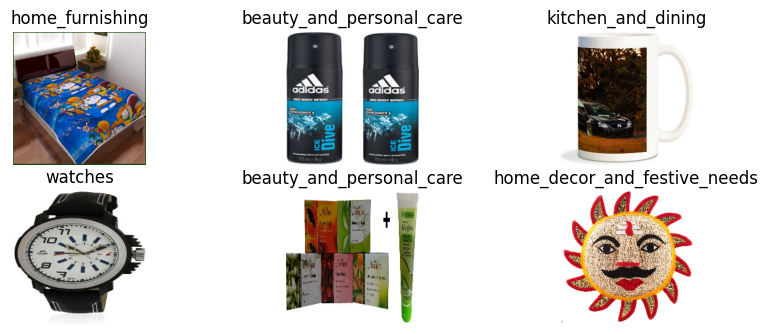

In [60]:
# visualize first items of the training dataset
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")


Above, Images are not pre-processed for the mobilenet.

## Datasets pre-processing and data augmentation

There are two ways to proceed data augmentation. It can be integrated to the model (as its first layers) or it can be made via the tf.data API which enables to build complex input pipelines.

It seems that when using a GPU and for simplicity in deploying models, the first way is better. 

Nevertheless, when using a CPU -- my case --, It is better to go with the tf.data.Dataset.

In [110]:
AUTOTUNE = tf.data.AUTOTUNE

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        # RandomZoom(0.1),
    ]
)

def prepare(ds, shuffle=False, augment=False):
    # Prepare the entry to the Mobilenet.
    ds = ds.map(
        lambda x, y: (tf.keras.applications.mobilenet.preprocess_input(x), y),
        num_parallel_calls=AUTOTUNE
    )
    
    ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(1050)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    # Use buffered prefetching on all datasets.
    return ds.prefetch(AUTOTUNE)


For now, let's not augment the data and see the results.

In [111]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)

2023-06-12 15:18:58.773021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [945]
	 [[{{node Placeholder/_0}}]]
2023-06-12 15:18:58.773863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [945]
	 [[{{node Placeholder/_0}}]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255]

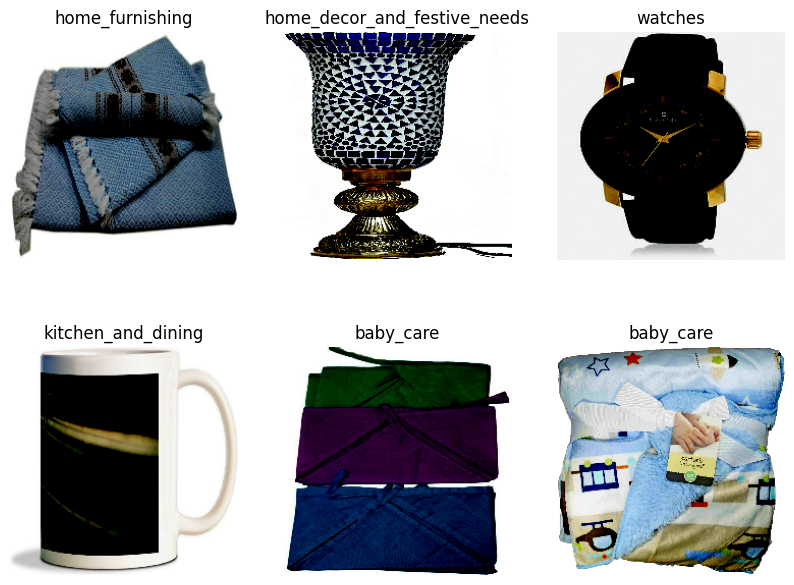

In [112]:
plt.figure(figsize=(10, 7.5))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy(), vmin=-1, vmax=1)
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

## 4.3.  [&#9650;](#toc0_) <a id='toc4_3_'></a>Create the classification model based on mobileNet

In [113]:
# Get the model
pre_trained_model = tf.keras.applications.mobilenet.MobileNet(
    weights="imagenet",
    input_shape=(224, 224, 3)
)

pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [114]:
n_classes = 7

# Create a sequential model based on mobileNet layers without the last layer#
model = Sequential()
for layer in pre_trained_model.layers[:-1]:
    model.add(layer)

# Freeze trainable parameters
for layer in model.layers:
    layer.trainable = False

# Adapt the output layer to my problem
model.add(Dense(units=n_classes, activation='softmax'))
model.layers[-1]._name = 'predictions'

print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 112, 112, 32)    

In [115]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [116]:
batch_size

8

In [17]:
# checkpoints
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [checkpoint, es]

In [117]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks_list,
)


Epoch 1/10


2023-06-12 15:20:16.683625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [945]
	 [[{{node Placeholder/_4}}]]
2023-06-12 15:20:16.684509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [945]
	 [[{{node Placeholder/_0}}]]
2023-06-12 15:20:45.700878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [105]
	 [


Epoch 1: val_accuracy improved from -inf to 0.78095, saving model to weights.best.hdf5
119/119 - 33s - loss: 1.9426 - accuracy: 0.6106 - val_loss: 1.5120 - val_accuracy: 0.7810 - 33s/epoch - 279ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.78095
119/119 - 38s - loss: 0.7733 - accuracy: 0.8085 - val_loss: 1.2598 - val_accuracy: 0.7714 - 38s/epoch - 323ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.78095
119/119 - 43s - loss: 0.5034 - accuracy: 0.8635 - val_loss: 1.0925 - val_accuracy: 0.7714 - 43s/epoch - 359ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.78095 to 0.79048, saving model to weights.best.hdf5
119/119 - 43s - loss: 0.3885 - accuracy: 0.8878 - val_loss: 1.1803 - val_accuracy: 0.7905 - 43s/epoch - 365ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.79048
119/119 - 42s - loss: 0.2345 - accuracy: 0.9302 - val_loss: 1.1828 - val_accuracy: 0.7905 - 42s/epoch - 356ms/step
Epoch 6/10

Epoch 6: val_accuracy did not impr

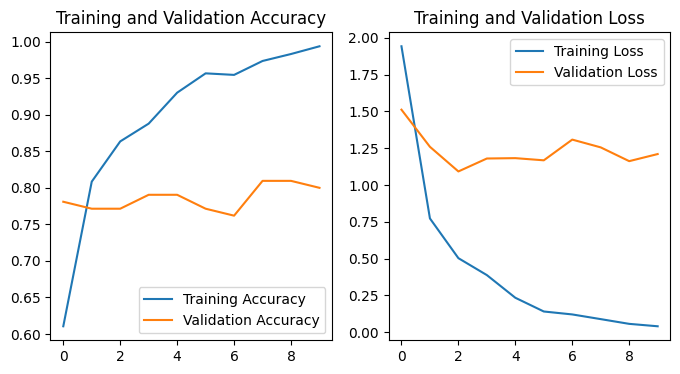

In [124]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


We can observe over-fitting because the training accuracy keeps improving but the validation accuracy is mostly stagnant.